In [1]:
import numpy as np
import os
import pandas as pd
import sys

project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)
from experiments.MNIST import ExperimentFactory, ExperimentType, ExperimentMNIST
from experiments.utils import generate_roc_df

In [2]:
def save_result(roc:list, auc:list, config:dict) -> tuple:
    '''
        Save the results of the experiment
        Args:
        -----
            roc: list
                List of roc curves
            auc: list
                List of AUC scores
            config: dict
                Configuration of the experiment

        Returns:
        --------
            roc_df: pd.DataFrame
                ROC Cuve dataFrame with multiindex, considering the iterations.
            auc_df: pd.DataFrame
                DataFrame with the AUC scores
    '''

    roc_df = generate_roc_df(roc)
    auc_df = pd.DataFrame({'AUC': auc}, index=['It {}'.format(x) for x in np.arange(len(auc))])
    
    # save
    roc_df.to_pickle(os.path.join(config['save_result_dir'], 'roc.pkl'))
    auc_df.to_csv(os.path.join(config['save_result_dir'], 'auc.csv'))
    
    return roc_df, auc_df

In [ ]:
from tqdm import tqdm
from matplotlib import pyplot as plt

n_iter = 2
iterator = tqdm(
            range(n_iter),
            leave=True,
            unit="It.",
            postfix={"AUC": "%.3f" % -1},
        )

# experiments_type = [ExperimentType.Anomalies_001,ExperimentType.Anomalies_005, ExperimentType.Anomalies_010, ExperimentType.Anomalies_020]
# experiments_type = [ExperimentType.Anomalies_010, ExperimentType.Anomalies_020]
experiments_type = [ExperimentType.Anomalies_005]

for experiment_type in experiments_type:
    auc, roc, auc_best_score = [], [], -1
    print('Experiment: {}'.format(experiment_type))
    for i in iterator:
        experiment = ExperimentFactory.create(experiment_type)
        if i == 0:
            config = experiment.config()
            experiment.save_config()
        experiment.run()

        tpr, fpr, roc_auc = experiment.to_test()
        roc.append((tpr, fpr))
        auc.append(roc_auc)

        iterator.set_postfix(tls="%.3f" % roc_auc)
        
        if roc_auc > auc_best_score:
            auc_score = roc_auc
            experiment.save_model(verbose=False)
            fig = experiment.plot_reconstructed(experiment.model, r0=(-6, 6), r1=(-6, 6), n=15 )
            fig.savefig(os.path.join(config['save_imgs_dir'], f'reconstructed.pdf'), bbox_inches='tight')
            plt.close(fig)

    roc_df, auc_df = save_result(roc, auc, config)

In [70]:
experiment = ExperimentFactory.create(ExperimentType.Anomalies_020, seed=42)
experiment.run()

In [79]:
import torch
from sklearn.metrics import roc_curve, auc

x, y = zip(*[(_x, _y) for _x, _y in experiment.test_dataset])
x = torch.stack(x)
y = torch.tensor(y)

_ = experiment.model(x)
sigma = experiment.model.bottleneck.sigma
normalize = np.log(2*torch.pi*torch.e)
y_score = 0.5 * (len(sigma) * normalize + torch.log(torch.sum(sigma, dim=1)).detach().numpy())
# y_score = normalize + torch.log(torch.prod(sigma, dim=1)).detach().numpy()
        
fpr, tpr, thresholds = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

roc_auc

0.9953418810744099

In [78]:
sigma.shape

torch.Size([2])

In [83]:
d, _ = torch.rand(10, 10, 10).shape

ValueError: too many values to unpack (expected 2)

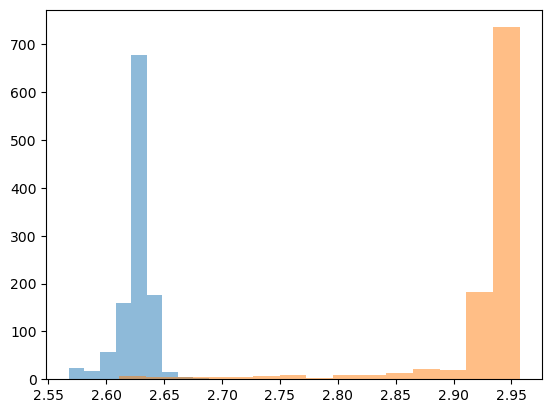

In [74]:
from matplotlib import pyplot as plt
plt.hist(y_score[y==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=15, alpha=0.5, label='Anomaly')
plt.show()

In [75]:
sigma = torch.tensor([1,1]) 
y_score_1 = 0.5* (normalize + torch.log(sigma).sum().detach().numpy())
y_score_2 = normalize + torch.log(sigma).sum().detach().numpy()
y_score_3 = torch.log(sigma).sum().detach().numpy()

print(y_score_1, y_score_2, y_score_3)

1.4189385332046727 2.8378770664093453 0.0


In [76]:
# Calcular la diferencia entre TPR y FPR para cada umbral
differences = tpr - fpr

# Encontrar el índice del umbral que maximiza la diferencia
optimal_threshold_index = np.argmax(differences)

# Obtener el umbral óptimo
optimal_threshold = thresholds[optimal_threshold_index]

print("Optimal threshold:", optimal_threshold)

Optimal threshold: 2.6897364


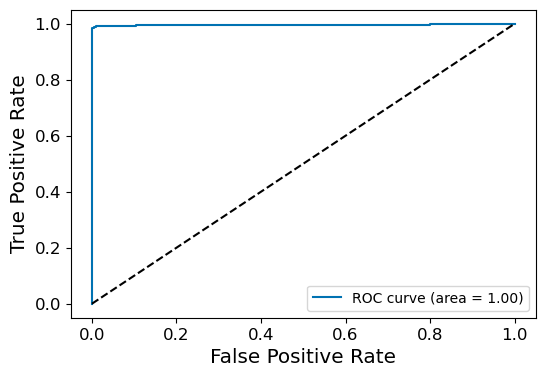

In [77]:
tpr, fpr, roc_auc = experiment.to_test()

with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize='x-large')
    plt.ylabel('True Positive Rate', fontsize='x-large')
    plt.legend(loc="lower right")

    plt.tick_params(axis='both', which='major', labelsize='large')

    plt.show()